In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. Исходные данные

In [2]:
# Фиксация генератора случайных чисел
random_seed = 1902    # 1902 1906
np.random.seed(random_seed)

# Значения предикторов для прогноза целевой переменной
A_complex_max = [1800 + 1000j, 1500 + 1000j, 1800 + 1400j, 2000 + 1700j, 1500 + 1200j]
# A_complex_max = [600 + 200j, 240 + 170j, 700 + 320j, 800 + 300j, 400 + 150j]

# Отн. погрешности измерений значений элементов матрицы A_h и вектора b_d
k_A = 0.0
k_b = 0.0

# Относительный размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [3]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel('C:\Datasets/dataset_z_complex_reg_acc.xlsx').astype(complex)
z_complex_acc.T

,0,1,2,3,4
0,0.04+0.02j,0.035+0.015j,0.03+0.02j,0.020+0.012j,0.016+0.010j


In [4]:
# Загрузка датасета с данными из комплексных чисел
df_complex = pd.read_excel('C:\Datasets/dataset_complex_reg_0.xlsx').astype(complex)
df_complex

,A_1,A_2,A_3,A_4,A_5,b
0,400.000000+150.000000j,200.000000+100.000000j,450.000000+200.000000j,600.000000+250.000000j,200.000000+100.000000j,39.200000+51.300000j
1,402.921928+151.095723j,202.692972+101.346486j,454.370301+201.942356j,608.072668+253.363612j,202.163405+101.081702j,39.606169+51.838551j
2,407.946486+152.979932j,205.209105+102.604553j,460.051609+204.467382j,616.801956+257.000815j,203.279482+101.639741j,40.101815+52.483147j
3,410.974495+154.115436j,206.254162+103.127081j,464.326150+206.367178j,625.846089+260.769204j,203.573525+101.786762j,40.458102+52.954767j
4,415.562242+155.835841j,207.159100+103.579550j,466.406392+207.291730j,632.910077+263.712532j,203.630516+101.815258j,40.782592+53.358750j
...,...,...,...,...,...,...
95,813.544949+305.079356j,416.805300+208.402650j,922.461153+409.982735j,1183.940560+493.308567j,434.083904+217.041952j,79.910568+104.655919j
96,819.670740+307.376527j,417.792649+208.896325j,929.962976+413.316878j,1185.061608+493.775670j,439.799087+219.899544j,80.374863+105.278139j
97,820.968624+307.863234j,421.856504+210.928252j,937.342687+416.596750j,1191.313698+496.380707j,444.891074+222.445537j,80.834387+105.920412j
98,828.110129+310.541298j,426.787797+213.393898j,947.095035+420.931127j,1204.042158+501.684233j,446.936050+223.468025j,81.621401+106.951332j


3. Попарные графики рассеяния модулей значений переменных датасета

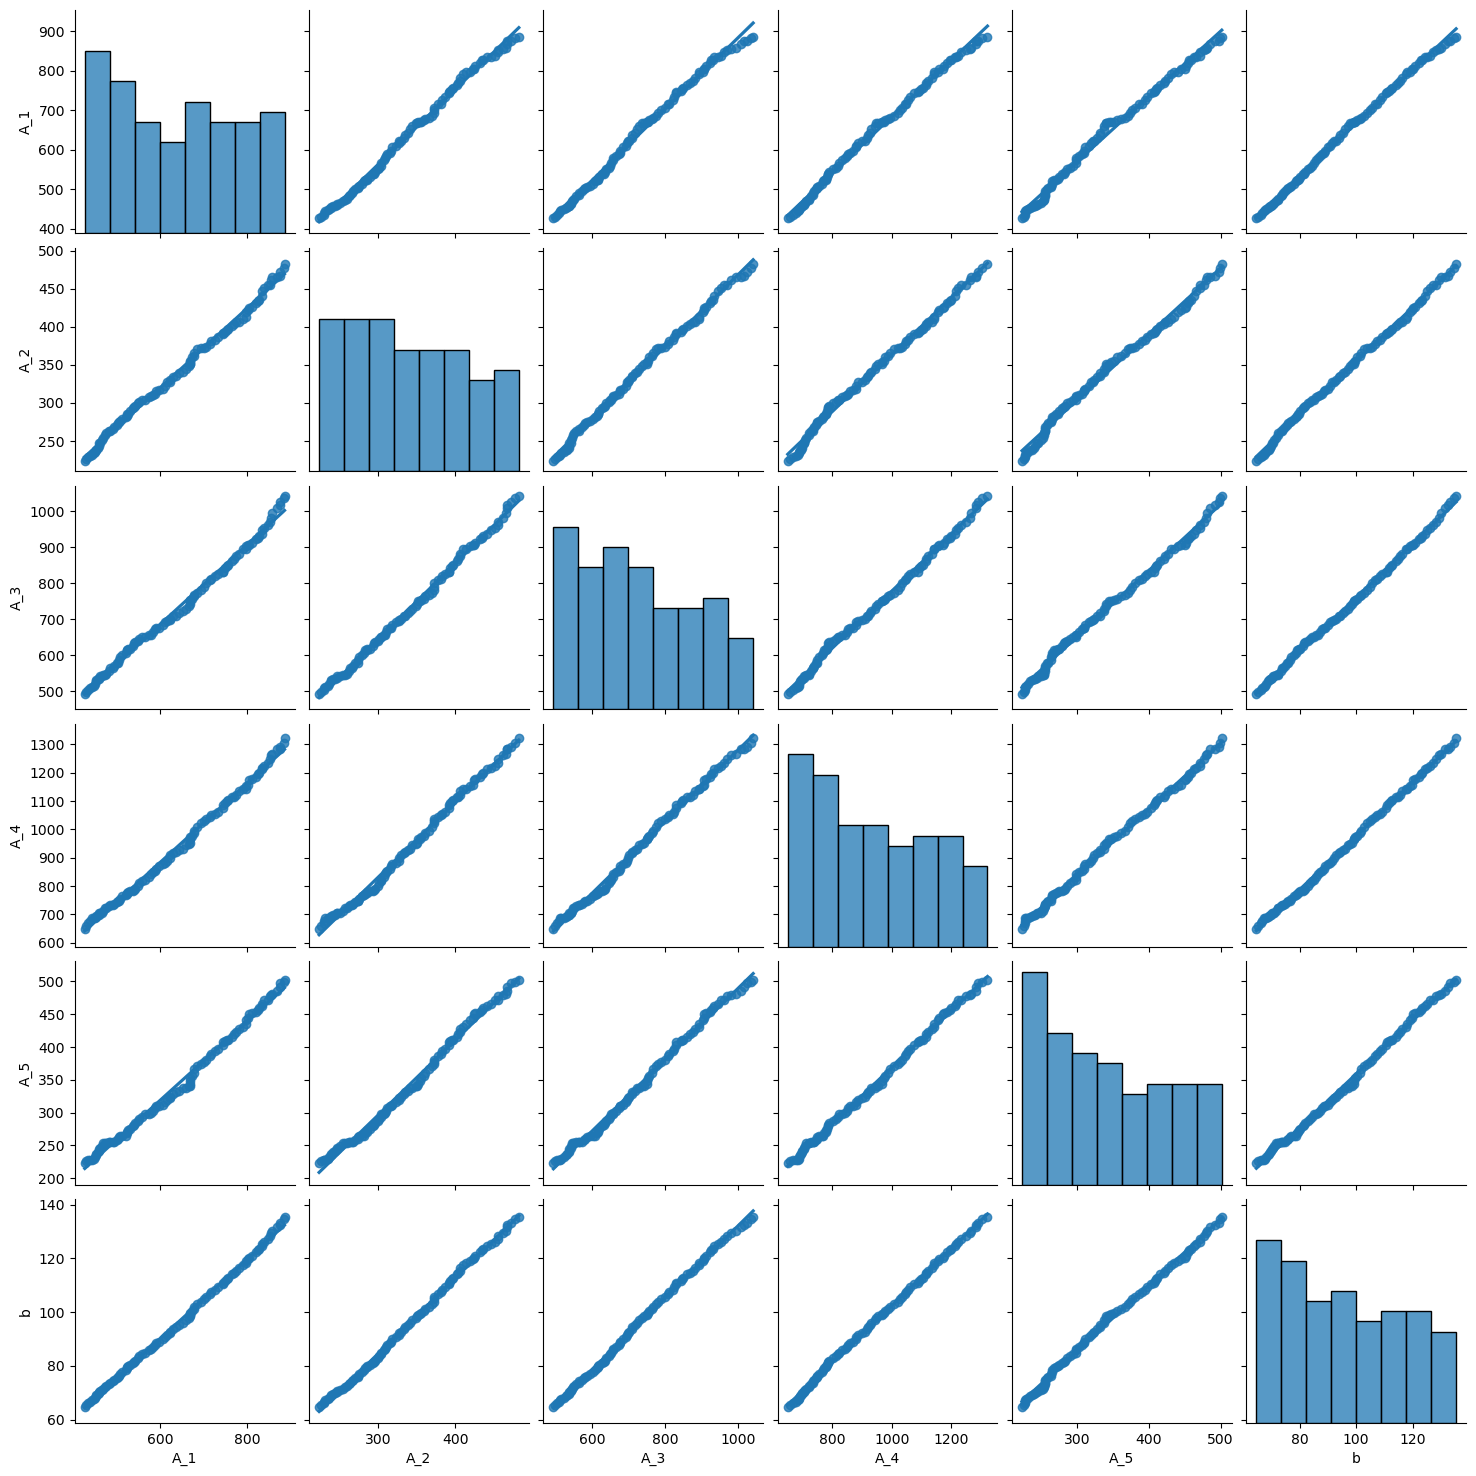

In [5]:
df_modul = df_complex.applymap(lambda x: abs(x))
sns.pairplot(df_modul, kind="reg")
plt.show()

4. Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_complex

In [6]:
A_complex = df_complex.iloc[:, :-1].values
b_complex = df_complex.iloc[:, -1].values
cond_A_complex = np.linalg.cond(A_complex.T @ A_complex)
det_A_complex = np.linalg.det(A_complex.T @ A_complex)

print(f'Число обусловленности матрицы A_complex: cond(A_complex) = {cond_A_complex.round(1)}')
print("Определитель матрицы A_complex:", det_A_complex)

Число обусловленности матрицы A_complex: cond(A_complex) = 235672.8
Определитель матрицы A_complex: (-6.146628533841858e+22-1.088051880170697e+23j)


5. Формирование вещественной матрицы A признаков и вещественного вектора b целевой переменной

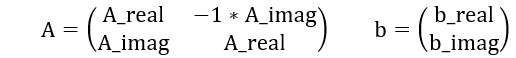


In [7]:
A_real = A_complex.real
A_imag = A_complex.imag
A_1 = pd.concat([pd.DataFrame(A_real), pd.DataFrame(A_imag)], axis=0)
A_2 = pd.concat([-1 * pd.DataFrame(A_imag), pd.DataFrame(A_real)], axis=0)
index_A = np.arange(A_1.shape[0])
A_1.index = index_A
A_2.index = index_A 
A = pd.merge(A_1, A_2, left_index=True, right_index=True)
A.columns = [f'A_{i+1}' for i in range(A.shape[1])]

In [8]:
b_real = b_complex.real
b_imag = b_complex.imag
b = pd.concat([pd.DataFrame(b_real), pd.DataFrame(b_imag)], axis=0)
b.index = index_A
b.columns = ['b']

6. Формирование вещественного вектора A_max для прогноза целевой переменной

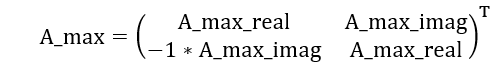

In [9]:
A_max_real = np.array(A_complex_max).real
A_max_imag = np.array(A_complex_max).imag
A_max_1 = pd.concat([pd.DataFrame(A_max_real), -1 * pd.DataFrame(A_max_imag)], axis=0)
A_max_2 = pd.concat([pd.DataFrame(A_max_imag), pd.DataFrame(A_max_real)], axis=0)
index_max = np.arange(A_max_1.shape[0])
A_max_1.index = index_max
A_max_2.index = index_max 
A_max = pd.merge(A_max_1, A_max_2, left_index=True, right_index=True)
A_max = A_max.T
A_max

,0,1,2,3,4,5,6,7,8,9
0_x,1800.0,1500.0,1800.0,2000.0,1500.0,-1000.0,-1000.0,-1400.0,-1700.0,-1200.0
0_y,1000.0,1000.0,1400.0,1700.0,1200.0,1800.0,1500.0,1800.0,2000.0,1500.0


7. Масштабирование признаков и вектора A_max

In [10]:
sc = MaxAbsScaler()    # MaxAbsScaler()    StandardScaler()

# Переход к привычным обозначениям X и y для признаков и целевых переменных
X_std = sc.fit_transform(A) 
# X_std = A_train 

y = b

In [11]:
A_max_std = sc.transform(A_max)
# A_max_std = A_max
pd.DataFrame(A_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9
0,2.169,3.48,1.89,1.640,3.343,-1.205,-2.32,-1.47,-1.394,-2.675
1,1.205,2.32,1.47,1.394,2.675,2.169,3.48,1.89,1.640,3.343


8. Обучение моделей регрессоров на train-данных

In [12]:
metrics = {}

8.1 LinearRegression

In [13]:
lr = LinearRegression()
model_lr = lr.fit(X_std, y)

y_lr_pred = model_lr.predict(X_std)

rmse_lr = np.sqrt(mean_squared_error(y, y_lr_pred)).round(3)
mae_lr = mean_absolute_error(y, y_lr_pred).round(3)
r2_lr = r2_score(y, y_lr_pred).round(3)
b_max_lr = model_lr.predict(A_max_std)[:].flatten().round(3)
b_max_lr_complex = complex(b_max_lr[0], b_max_lr[1])
b_max_lr_modul = np.sqrt(b_max_lr[0]**2 + b_max_lr[1]**2).round(3)
metrics['LinRegr'] = (str(r2_lr), b_max_lr_complex, str(b_max_lr_modul))

print(f'RMSE: {rmse_lr}')
print()
print(f'MAE:  {mae_lr}')
print()
print(f'R2:   {r2_lr}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_lr_complex}')
print(f'b max_modul:   {b_max_lr_modul}')
print()
print('Коэффициенты регрессии:')
print(pd.DataFrame(model_lr.coef_.flatten(), columns=['k']).round(3))
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')

RMSE: 0.0

MAE:  0.0

R2:   1.0

Прогноз целевой переменной:
b max_complex: (147.1+303.7j)
b max_modul:   337.449

Коэффициенты регрессии:
        k
0  33.196
1  15.088
2  28.579
3  24.391
4   7.178
5  16.598
6   6.466
7  19.052
8  14.635
9   4.487
Свободный член регрессии  a0 =  [0.]


8.2 Ridge

In [14]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-10, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_std, y)

y_rid_pred = model_rid.predict(X_std)

rmse_rid = np.sqrt(mean_squared_error(y, y_rid_pred)).round(3)
mae_rid = mean_absolute_error(y, y_rid_pred).round(3)
r2_rid = r2_score(y, y_rid_pred).round(3)

b_max_rid = model_rid.predict(A_max_std)[:].flatten().round(3)
b_max_rid_complex = complex(b_max_rid[0], b_max_rid[1])
b_max_rid_modul = np.sqrt(b_max_rid[0]**2 + b_max_rid[1]**2).round(3)
metrics['Ridge'] = (str(r2_rid), b_max_rid_complex, str(b_max_rid_modul))

print(f'RMSE: {rmse_rid}')
print()
print(f'MAE:  {mae_rid}')
print()
print(f'R2:   {r2_rid}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_rid_complex}')
print(f'b max_modul:   {b_max_rid_modul}')
model_rid.best_params_

RMSE: 0.0

MAE:  0.0

R2:   1.0

Прогноз целевой переменной:
b max_complex: (147.1+303.7j)
b max_modul:   337.449


{'alpha': 1e-10, 'random_state': 1}

8.3 TheilSenRegressor

In [15]:
tsr = TheilSenRegressor()
tsr_parameters = {'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_std, y)

y_tsr_pred = model_tsr.predict(X_std)

rmse_tsr = np.sqrt(mean_squared_error(y, y_tsr_pred)).round(3)
mae_tsr = mean_absolute_error(y, y_tsr_pred).round(3)
r2_tsr = r2_score(y, y_tsr_pred).round(3)
b_max_tsr = model_tsr.predict(A_max_std).round(3)
b_max_tsr_complex = complex(b_max_tsr[0], b_max_tsr[1])
b_max_tsr_modul = np.sqrt(b_max_tsr[0]**2 + b_max_tsr[1]**2).round(3)
metrics['TheilSen'] = (str(r2_tsr), b_max_tsr_complex, str(b_max_tsr_modul))

print(f'RMSE: {rmse_tsr}')
print()
print(f'MAE:  {mae_tsr}')
print()
print(f'R2:   {r2_tsr}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_tsr_complex}')
print(f'b max_modul:   {b_max_tsr_modul}')
model_tsr.best_params_

RMSE: 0.0

MAE:  0.0

R2:   1.0

Прогноз целевой переменной:
b max_complex: (147.1+303.701j)
b max_modul:   337.45


{'random_state': 100}

9. Средние значения метрик регрессоров и целевой переменной b

In [16]:
r2_values = [metrics[key][-3] for key in metrics]
r2_values = [float(value) for value in r2_values[:-1]]
r2_mean = round(sum(r2_values) / len(r2_values), 3)
b_max_values = [metrics[key][-2] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
b_max_real_round = round(b_max_mean.real, 3)
b_max_imag_round = round(b_max_mean.imag, 3)
b_max_mean_complex = complex(b_max_real_round, b_max_imag_round)
b_max_mean_modul = np.sqrt(b_max_real_round**2 + b_max_imag_round**2).round(3)
metrics['Mean'] = (str(r2_mean), b_max_mean_complex, str(b_max_mean_modul))

print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {b_max_mean_complex}')
print(f'b_max_mean_modul: {b_max_mean_modul}')

Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (147.1+303.7j)
b_max_mean_modul: 337.449


10. Определение коэффициента регуляризации alpha методом обобщенной невязки

In [17]:
# Функция вычисления обобщенной невязки delta_residual
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2

    return delta_residual


X_h = X_std
y_d = y
# Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
h = k_A * np.linalg.norm(X_h)
d = k_b * np.linalg.norm(y_d)

print(h)
print(d)

# Поиск коэффициента регуляризации alpha
calculate_delta_residual_partial = partial(calculate_delta_residual, X=X_h, y=y_d, h=h, d=d)
alpha = newton(calculate_delta_residual_partial, x0=1e-7, tol=1e-7, maxiter=1000)
# alpha = bisect(calculate_delta_residual_partial, 1e-7, 1e5)
# alpha = brentq(calculate_delta_residual_partial, a=1e-7, b=1e5, xtol=1e-7)

print(f"Коэффициент регуляризации alpha = {alpha:.{2}e}")

0.0
0.0
Коэффициент регуляризации alpha = 9.98e-08


11. Регуляризированное решение системы уравнений

In [18]:
# Регуляризованное решение
z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

y_reg_hd_pred = X_std @ z_hd

rmse_reg_hd = np.sqrt(mean_squared_error(y, y_reg_hd_pred)).round(3)
mae_reg_hd = mean_absolute_error(y, y_reg_hd_pred).round(3)
r2_reg_hd = r2_score(y, y_reg_hd_pred).round(3)
b_max_reg_hd = np.dot(np.array(A_max_std), np.array(z_hd)).round(3)
b_max_reg_hd_complex = complex(b_max_reg_hd[0], b_max_reg_hd[1])
b_max_reg_hd_modul = np.sqrt(b_max_reg_hd[0]**2 + b_max_reg_hd[1]**2).round(3)
metrics['Regularized'] = (str(r2_reg_hd), b_max_reg_hd_complex, str(b_max_reg_hd_modul[0]))

print(f'RMSE: {rmse_reg_hd}')
print()
print(f'MAE:  {mae_reg_hd}')
print()
print(f'R2:   {r2_reg_hd}')
print()
print(f'Прогноз целевой переменной:')
print(f'b_max_reg_hd_complex: {b_max_reg_hd_complex}')
print(f'b_max_reg_hd_modul:   {b_max_reg_hd_modul[0]}')
print()
z_hd

RMSE: 0.0

MAE:  0.0

R2:   1.0

Прогноз целевой переменной:
b_max_reg_hd_complex: (147.1+303.701j)
b_max_reg_hd_modul:   337.45



,b
0,33.195478
1,15.088531
2,28.578252
3,24.391349
4,7.178487
5,16.597746
6,6.466559
7,19.052135
8,14.634814
9,4.486542


In [19]:
# N_feat = X_h.shape[1]

# print("Точные масштабированные коэффициенты регрессии:")
# for i in range(0, N_feat): 
#     print((np.array(z_complex_acc)[i] * np.amax(A[:, i])).round(2))
# print()
# print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
# print("Регуляризованные масштабированные коэффициенты регрессии:")
# for i in range(0, N_feat): 
#     print(z_hd[i].round(2))

12. Точный прогноз целевой переменной b

In [20]:
b_max_acc_complex = np.dot(np.array(A_complex_max), np.array(z_complex_acc)).round(3)
b_max_acc_modul = abs(b_max_acc_complex).round(3)
metrics['Accurate'] = ('', b_max_acc_complex[0], b_max_acc_modul[0])

print(f'Точный прогноз целевой переменной по известным точным коэффициентам регрессии:')
print(f'b_max_acc_complex: {b_max_acc_complex[0]}')
print(f'b_max_acc_modul: {b_max_acc_modul[0]}')

Точный прогноз целевой переменной по известным точным коэффициентам регрессии:
b_max_acc_complex: (147.1+303.7j)
b_max_acc_modul: 337.449


13. Сводная таблица метрик и прогнозов моделей

In [21]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2', 'b_max_complex', 'b_max_modul']
df_metrics = df_metrics.astype(object)
df_metrics

,LinRegr,Ridge,TheilSen,Mean,Regularized,Accurate
R2,1.0,1.0,1.0,1.0,1.0,
b_max_complex,(147.1+303.7j),(147.1+303.7j),(147.1+303.701j),(147.1+303.7j),(147.1+303.701j),(147.1+303.7j)
b_max_modul,337.449,337.449,337.45,337.449,337.45,337.449
